## Machine Learning - Models (data modify)

In [1]:
# import libs

import itertools
import matplotlib.pyplot as plt
import lightgbm as lgb
import numpy as np
import pandas as pd
import sklearn
import time

from catboost import Pool, CatBoostClassifier
from scipy.spatial.distance import euclidean, mahalanobis, minkowski, chebyshev
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import DistanceMetric
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import shuffle
from sklearn import metrics

%matplotlib inline

# import warnings
# warnings.filterwarnings('always') # "error", "ignore", "always", "default", "module" or "once"

**Load data (csv file + features)**

In [2]:
path='features.csv'
df=pd.read_csv(path, sep=",")
df.head(10)

,time,lat,lon,alt,label,user,delta_time,distance,speed,acceleration,...,distance_10,speed_10,acceleration_10,jerk_10,bearing_10,bearing_rate_10,elevation_change_10,elevation_speed_10,elevation_angle_10,elevation_distance_10
0,2008-03-28 14:54:40,39.894178,116.318200,-777.0,6,10,34.0,253.375124,7.452210,0.008984,...,7004.449301,28.591177,0.037348,0.000050,180.584289,0.387508,0.0,0.0,0.110478,0.0
1,2008-03-28 14:55:14,39.894505,116.321132,-777.0,6,10,59.0,457.703187,7.757681,0.018562,...,8648.936946,29.530746,0.036779,0.000031,180.105377,0.251844,0.0,0.0,0.089597,0.0
2,2008-03-28 14:56:13,39.894953,116.326452,-777.0,6,10,59.0,522.318591,8.852857,0.043408,...,10411.256219,31.464909,0.038196,-0.000009,179.531741,0.876661,0.0,0.0,0.074493,0.0
3,2008-03-28 14:57:12,39.894600,116.332542,-777.0,6,10,59.0,673.422399,11.413939,0.048946,...,12254.781563,31.509769,0.033946,-0.000025,178.891087,1.407696,0.0,0.0,0.063319,0.0
4,2008-03-28 14:58:11,39.889622,116.337040,-777.0,6,10,59.0,843.803760,14.301759,0.015336,...,13621.904751,29.131200,0.025050,0.000016,178.362414,1.724043,0.0,0.0,0.056979,0.0
5,2008-03-28 14:59:10,39.882090,116.338353,-777.0,6,10,60.0,912.394041,15.206567,0.019319,...,14544.387148,19.515034,0.007278,-0.000020,178.061995,1.944676,0.0,0.0,0.053372,0.0
6,2008-03-28 15:00:10,39.873873,116.338455,-777.0,6,10,59.0,965.577796,16.365725,0.034649,...,14680.422099,15.571418,-0.001342,-0.000061,178.274790,1.699422,0.0,0.0,0.052878,0.0
7,2008-03-28 15:01:09,39.865182,116.338058,-777.0,6,10,59.0,1086.189677,18.409995,0.044349,...,14448.932045,11.119672,-0.012315,-0.000096,178.547551,1.430031,0.0,0.0,0.053724,0.0
8,2008-03-28 15:02:08,39.855403,116.337710,-777.0,6,10,59.0,1240.567528,21.026568,0.085104,...,14213.822264,9.920764,-0.017656,-0.000163,178.870938,0.915318,0.0,0.0,0.054611,0.0
9,2008-03-28 15:03:07,39.844532,116.334362,-777.0,6,10,59.0,1536.815794,26.047725,0.043109,...,13378.801666,9.384254,-0.026492,-0.000111,179.249652,0.355888,0.0,0.0,0.058012,0.0


**Data describe**

In [3]:
# data size
print('shape: ', df.shape)

shape:  (5427092, 28)


In [4]:
# data info
df.describe()

,lat,lon,alt,label,user,delta_time,distance,speed,acceleration,jerk,...,distance_10,speed_10,acceleration_10,jerk_10,bearing_10,bearing_rate_10,elevation_change_10,elevation_speed_10,elevation_angle_10,elevation_distance_10
count,5.427092e+06,5.427092e+06,5.427092e+06,5.427092e+06,5.427092e+06,5.427092e+06,5.427092e+06,5.427092e+06,5.427092e+06,5.427092e+06,...,5.427092e+06,5.427092e+06,5.427092e+06,5.427092e+06,5.427092e+06,5.427092e+06,5.427092e+06,5.427092e+06,5.427092e+06,5.427092e+06
mean,3.947129e+01,1.145119e+02,5.886054e+02,3.120512e+00,9.483799e+01,3.639555e+01,2.182172e+01,6.800245e+00,-1.369530e-01,1.242073e-01,...,3.433303e+02,6.800244e+00,-2.584894e-03,5.684083e-02,1.807330e+02,2.162920e+00,1.583897e+01,2.648258e+02,7.488712e-01,3.321015e+05
std,2.370483e+00,1.517699e+01,2.408164e+03,2.340513e+00,4.843452e+01,1.279890e+03,9.749392e+02,1.217480e+01,2.798553e+00,3.055347e+00,...,2.016520e+04,1.217480e+01,3.590297e-01,5.497709e-01,4.763486e+01,2.657080e+01,2.171753e+02,1.151858e+04,6.275989e-01,6.466291e+07
min,1.824990e+01,-1.799696e+02,-2.304130e+04,1.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,-4.151598e+03,-3.113526e+03,...,0.000000e+00,0.000000e+00,-1.976058e+02,-1.092319e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.992305e+01,1.163092e+02,0.000000e+00,1.000000e+00,6.500000e+01,1.000000e+00,1.552118e+00,6.877849e-01,-2.037990e-01,-9.571910e-02,...,1.582473e+01,6.877849e-01,-3.892022e-02,-6.518013e-03,1.799841e+02,2.865842e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,3.997506e+01,1.163317e+02,1.250000e+02,3.000000e+00,8.500000e+01,2.000000e+00,4.975839e+00,2.378576e+00,0.000000e+00,0.000000e+00,...,4.736118e+01,2.378576e+00,0.000000e+00,0.000000e+00,1.800000e+02,1.300981e-02,3.200000e+00,4.111952e+00,7.914602e-01,9.655472e+01
75%,3.999121e+01,1.164182e+02,1.940000e+02,4.000000e+00,1.390000e+02,2.000000e+00,1.671154e+01,9.139715e+00,1.513558e-01,1.515684e-01,...,1.640956e+02,9.139735e+00,3.837053e-02,9.850401e-03,1.800147e+02,6.707147e-02,1.300000e+01,6.231829e+01,1.399894e+00,1.290484e+03
max,5.876549e+01,1.799969e+02,5.196190e+04,1.100000e+01,1.790000e+02,8.633400e+04,2.060860e+06,6.605319e+03,2.075453e+03,4.151666e+03,...,8.709757e+06,6.605319e+03,2.265971e+02,1.882853e+02,3.600000e+02,3.600000e+02,5.197830e+04,1.098988e+07,1.570791e+00,2.255770e+10


In [5]:
# target count
count_data = df['label'].groupby(df['label']).count()
print('type: ', count_data)

type:  label
1     1585401
2      948061
3     1276632
4      512807
5      286144
6      560978
7        9183
8        3559
9        1971
10        338
11     242018
Name: label, dtype: int64


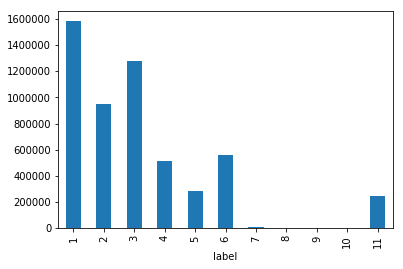

In [6]:
# count target plot
count_data.plot('bar');

**Preprocessing data**

Reducing data by slicing && evaluating slicing koefficients

In [7]:
# stepped data
dff = df.copy()

In [8]:
# data frame for each lable
data_labled = [dff[(dff['label'] == i+1)] for i in range(11)]

# shape for each lable
data_proportion = [data.shape[0] for data in data_labled]

print('data proportion:', data_proportion)

data proportion: [1585401, 948061, 1276632, 512807, 286144, 560978, 9183, 3559, 1971, 338, 242018]


In [9]:
#Reducing data

data_labled_reduced = [data for ind, data in enumerate(data_labled) if ind not in [7,6,8,9] ]

data_proportion_reduced = [data.shape[0] for data in data_labled_reduced]

print('data proportion reduced:', data_proportion_reduced)

data proportion reduced: [1585401, 948061, 1276632, 512807, 286144, 560978, 242018]


In [10]:
# slicing dataframes by steps
data_reduced = [data.iloc[::5] for data in data_labled_reduced]

print('Result size of dataframes: ', [data.shape[0] for data in data_reduced])

Result size of dataframes:  [317081, 189613, 255327, 102562, 57229, 112196, 48404]


In [11]:
# slicing dataframes
data_reduced = [data.iloc[:20000] for data in data_reduced]

print('Result size of dataframes: ', [data.shape[0] for data in data_reduced])

Result size of dataframes:  [20000, 20000, 20000, 20000, 20000, 20000, 20000]


In [12]:
# Concatanate for result dataframe
dff = pd.concat(data_reduced, ignore_index=True)

print('Old size dataframe:    ', df.shape[0])
print('Result size dataframe: ', dff.shape[0])

Old size dataframe:     5427092
Result size dataframe:  140000


In [13]:
# Data info
dff.describe()

,lat,lon,alt,label,user,delta_time,distance,speed,acceleration,jerk,...,distance_10,speed_10,acceleration_10,jerk_10,bearing_10,bearing_rate_10,elevation_change_10,elevation_speed_10,elevation_angle_10,elevation_distance_10
count,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000,...,1.400000e+05,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000,140000.000000,1.400000e+05
mean,39.332514,113.333180,322.804055,4.571429,37.217229,28.663350,29.376180,8.329842,-0.250469,0.240310,...,5.197313e+02,8.327566,-0.003745,0.113586,186.377504,2.801672,10.641314,103.970644,0.597247,6.868702e+04
std,2.723630,12.600114,1679.668316,3.063955,27.867062,1155.279322,292.734033,9.688574,2.315019,2.698470,...,3.404730e+04,9.691097,0.349069,0.889243,63.832547,29.779832,157.149608,967.084397,0.611041,7.804138e+06
min,18.250767,-122.296646,-777.000000,1.000000,10.000000,0.000000,0.000000,0.000000,-207.098323,-71.238539,...,0.000000e+00,0.000000,-37.478070,-4.653137,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,39.875859,116.303430,0.000000,2.000000,10.000000,1.000000,1.624829,0.985075,-0.264448,-0.182226,...,1.552847e+01,0.977769,-0.054294,-0.011629,179.976829,0.004047,0.000000,0.000000,0.000000,0.000000e+00
50%,39.975023,116.327675,33.000000,4.000000,20.000000,1.000000,5.564940,3.815628,0.000000,0.000000,...,5.006682e+01,3.803728,0.000000,0.000000,180.000120,0.019146,0.000000,0.000000,0.380850,0.000000e+00
75%,39.986237,116.389479,164.000000,6.000000,65.000000,2.000000,18.528012,13.996830,0.187379,0.290246,...,1.854195e+02,13.997909,0.050813,0.018024,180.026025,0.083709,10.000000,68.146081,1.252560,1.083752e+03
max,47.576961,125.318928,51535.400000,11.000000,89.000000,85318.000000,55157.098982,463.505033,51.171703,137.041506,...,8.709733e+06,463.505033,41.290937,15.420023,359.999945,359.999945,51338.500000,238538.497998,1.570783,1.404474e+09


In [14]:
# target count
count_data = dff['label'].groupby(dff['label']).count()
print('type: ', count_data)

type:  label
1     20000
2     20000
3     20000
4     20000
5     20000
6     20000
11    20000
Name: label, dtype: int64


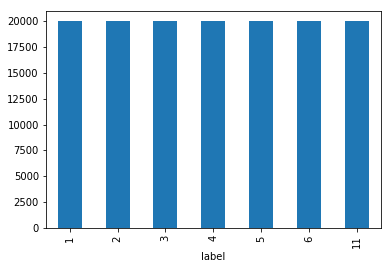

In [15]:
# count target plot
count_data.plot('bar');

**Data input && Splitting data**

In [16]:
# get column titles except the target column
features = dff.columns.tolist()
features.remove('label')
features.remove('time')
print(features)

['lat', 'lon', 'alt', 'user', 'delta_time', 'distance', 'speed', 'acceleration', 'jerk', 'bearing', 'bearing_rate', 'elevation_change', 'elevation_speed', 'elevation_angle', 'elevation_distance', 'delta_time_10', 'distance_10', 'speed_10', 'acceleration_10', 'jerk_10', 'bearing_10', 'bearing_rate_10', 'elevation_change_10', 'elevation_speed_10', 'elevation_angle_10', 'elevation_distance_10']


Get data set features and labels

In [17]:
# Features
X=dff[features].values
# labels
y=dff['label'].values

In [18]:
# split data to train data set and test data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1, stratify=y)

In [19]:
# Feature Scaling

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### **Model Classificator**

**Random Forest**

In [20]:
# Random Forest model
t_start = time.clock()

rf_classifier = RandomForestClassifier(n_estimators = 1000)
rf_classifier.fit(X_train, y_train)
#print(f'prediction precision rate: {rf_classifier.score(X_test, y_test):.5f} \n')

# Scores for Random Forest
y_pred = rf_classifier.predict(X_test)
train_score = rf_classifier.score(X_train, y_train)
test_score = rf_classifier.score(X_test, y_test)

t_end = time.clock()
t_diff = t_end - t_start

print(f"Random Forest:  {t_diff:.2f} s. --->>> Score on training / test set: {train_score:.5f} / {test_score:.5f} \n")
print(f'accuracy_score = {accuracy_score(y_test, y_pred):.5f}')
print(f'precision_score = {precision_score(y_test, y_pred, average="macro"):.5f}')
print(f'recall_score = {recall_score(y_test, y_pred, average="macro"):.5f}')
print(f'f1_score = {f1_score(y_test, y_pred, average="macro"):.5f} \n')
#print('roc_auc_score = ', roc_auc_score(y_train, y_pred))

Random Forest:  1515.26 s. --->>> Score on training / test set: 1.00000 / 0.94906 

accuracy_score = 0.94906
precision_score = 0.94951
recall_score = 0.94906
f1_score = 0.94918 



Feature importances

In [21]:
list(zip(features, rf_classifier.feature_importances_))

[('lat', 0.14165176810551372),
 ('lon', 0.14589952971044198),
 ('alt', 0.04607481181671655),
 ('user', 0.15776784894315302),
 ('delta_time', 0.03060088555763133),
 ('distance', 0.04317391893838474),
 ('speed', 0.050752217018080546),
 ('acceleration', 0.009928692687523132),
 ('jerk', 0.009761406456826596),
 ('bearing', 0.021899512193230858),
 ('bearing_rate', 0.012688297761875265),
 ('elevation_change', 0.002250951973461279),
 ('elevation_speed', 0.00303110634435941),
 ('elevation_angle', 0.018318908667751876),
 ('elevation_distance', 0.0031445976600386633),
 ('delta_time_10', 0.05311763583087897),
 ('distance_10', 0.06461793219284384),
 ('speed_10', 0.04958869246504643),
 ('acceleration_10', 0.01620025567078818),
 ('jerk_10', 0.01105958049799793),
 ('bearing_10', 0.027845384685480423),
 ('bearing_rate_10', 0.03293134434115915),
 ('elevation_change_10', 0.008030234839626256),
 ('elevation_speed_10', 0.007579521765853591),
 ('elevation_angle_10', 0.02342459869319247),
 ('elevation_distan

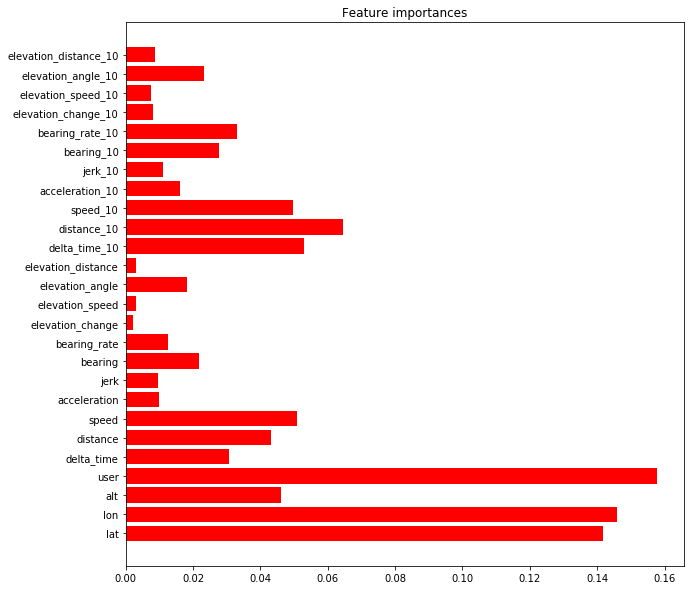

In [22]:
# Plot the feature importances of the forest
plt.figure(figsize=(10,10))
plt.title("Feature importances")
plt.barh(features, rf_classifier.feature_importances_,
       color="r", align="center")
plt.show()

**CatBoost**

In [27]:
# Feature Scaling Normalized

sc = StandardScaler()
X = sc.fit_transform(X)

In [28]:
# split data to train data set and test data set

X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.2, random_state=1, stratify=y_val_test)

In [29]:
#Creating Pool of train and test
train_pool = Pool(data=X_train, label=y_train)
val_pool = Pool(data=X_val, label=y_val) 

#Categorical features declaration
cat_features = list(range(0, X_train.shape[1]))
#print('cat features:', cat_features)

In [33]:
# Model
model = CatBoostClassifier(
    iterations=5000,
    learning_rate=0.1,
    random_strength=0.1,
    depth=8,
    loss_function='MultiClass',
    eval_metric='Accuracy',
    leaf_estimation_method='Newton',
    early_stopping_rounds=100)

In [34]:
#Fitting
model.fit(train_pool,
          plot=True,
          eval_set=val_pool)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7004018	test: 0.7007589	best: 0.7007589 (0)	total: 1.17s	remaining: 1h 37m 39s
1:	learn: 0.7469375	test: 0.7481250	best: 0.7481250 (1)	total: 2.44s	remaining: 1h 41m 49s
2:	learn: 0.7642679	test: 0.7656696	best: 0.7656696 (2)	total: 3.67s	remaining: 1h 42m 1s
3:	learn: 0.7697054	test: 0.7708036	best: 0.7708036 (3)	total: 4.79s	remaining: 1h 39m 49s
4:	learn: 0.7719643	test: 0.7739732	best: 0.7739732 (4)	total: 5.93s	remaining: 1h 38m 44s
5:	learn: 0.7763125	test: 0.7780357	best: 0.7780357 (5)	total: 7.16s	remaining: 1h 39m 16s
6:	learn: 0.7824196	test: 0.7826786	best: 0.7826786 (6)	total: 8.53s	remaining: 1h 41m 26s
7:	learn: 0.7845268	test: 0.7840625	best: 0.7840625 (7)	total: 9.57s	remaining: 1h 39m 33s
8:	learn: 0.7901607	test: 0.7917411	best: 0.7917411 (8)	total: 10.9s	remaining: 1h 41m 10s
9:	learn: 0.7938661	test: 0.7950000	best: 0.7950000 (9)	total: 12.1s	remaining: 1h 40m 58s
10:	learn: 0.8048661	test: 0.8049554	best: 0.8049554 (10)	total: 13.2s	remaining: 1h 40m 5s

89:	learn: 0.9120179	test: 0.9087500	best: 0.9087500 (89)	total: 1m 37s	remaining: 1h 29m 4s
90:	learn: 0.9124732	test: 0.9093304	best: 0.9093304 (90)	total: 1m 39s	remaining: 1h 29m 3s
91:	learn: 0.9127946	test: 0.9097768	best: 0.9097768 (91)	total: 1m 40s	remaining: 1h 28m 58s
92:	learn: 0.9131607	test: 0.9101786	best: 0.9101786 (92)	total: 1m 41s	remaining: 1h 28m 57s
93:	learn: 0.9133036	test: 0.9100893	best: 0.9101786 (92)	total: 1m 42s	remaining: 1h 28m 56s
94:	learn: 0.9136339	test: 0.9108036	best: 0.9108036 (94)	total: 1m 43s	remaining: 1h 29m 4s
95:	learn: 0.9142054	test: 0.9121875	best: 0.9121875 (95)	total: 1m 44s	remaining: 1h 29m 5s
96:	learn: 0.9146339	test: 0.9126786	best: 0.9126786 (96)	total: 1m 45s	remaining: 1h 29m 5s
97:	learn: 0.9149554	test: 0.9130804	best: 0.9130804 (97)	total: 1m 46s	remaining: 1h 29m 5s
98:	learn: 0.9152232	test: 0.9130357	best: 0.9130804 (97)	total: 1m 47s	remaining: 1h 29m 3s
99:	learn: 0.9154643	test: 0.9131696	best: 0.9131696 (99)	total: 1m

176:	learn: 0.9329911	test: 0.9281696	best: 0.9281696 (176)	total: 3m 12s	remaining: 1h 27m 17s
177:	learn: 0.9331250	test: 0.9286161	best: 0.9286161 (177)	total: 3m 13s	remaining: 1h 27m 15s
178:	learn: 0.9333661	test: 0.9290179	best: 0.9290179 (178)	total: 3m 14s	remaining: 1h 27m 13s
179:	learn: 0.9336161	test: 0.9291071	best: 0.9291071 (179)	total: 3m 15s	remaining: 1h 27m 12s
180:	learn: 0.9339643	test: 0.9298214	best: 0.9298214 (180)	total: 3m 16s	remaining: 1h 27m 10s
181:	learn: 0.9339643	test: 0.9300000	best: 0.9300000 (181)	total: 3m 17s	remaining: 1h 27m 7s
182:	learn: 0.9343125	test: 0.9302232	best: 0.9302232 (182)	total: 3m 18s	remaining: 1h 27m 9s
183:	learn: 0.9343839	test: 0.9302232	best: 0.9302232 (182)	total: 3m 19s	remaining: 1h 27m 12s
184:	learn: 0.9349018	test: 0.9309821	best: 0.9309821 (184)	total: 3m 20s	remaining: 1h 27m 7s
185:	learn: 0.9351071	test: 0.9308929	best: 0.9309821 (184)	total: 3m 21s	remaining: 1h 27m 5s
186:	learn: 0.9351250	test: 0.9310714	best: 

262:	learn: 0.9437768	test: 0.9375893	best: 0.9375893 (262)	total: 4m 44s	remaining: 1h 25m 21s
263:	learn: 0.9438304	test: 0.9375893	best: 0.9375893 (262)	total: 4m 45s	remaining: 1h 25m 19s
264:	learn: 0.9438125	test: 0.9378571	best: 0.9378571 (264)	total: 4m 46s	remaining: 1h 25m 19s
265:	learn: 0.9440000	test: 0.9379911	best: 0.9379911 (265)	total: 4m 47s	remaining: 1h 25m 16s
266:	learn: 0.9440357	test: 0.9379464	best: 0.9379911 (265)	total: 4m 48s	remaining: 1h 25m 14s
267:	learn: 0.9440625	test: 0.9379018	best: 0.9379911 (265)	total: 4m 49s	remaining: 1h 25m 12s
268:	learn: 0.9441518	test: 0.9379911	best: 0.9379911 (265)	total: 4m 50s	remaining: 1h 25m 15s
269:	learn: 0.9442054	test: 0.9383036	best: 0.9383036 (269)	total: 4m 51s	remaining: 1h 25m 14s
270:	learn: 0.9442500	test: 0.9383036	best: 0.9383036 (269)	total: 4m 53s	remaining: 1h 25m 13s
271:	learn: 0.9444107	test: 0.9382143	best: 0.9383036 (269)	total: 4m 54s	remaining: 1h 25m 14s
272:	learn: 0.9446250	test: 0.9382143	be

348:	learn: 0.9510625	test: 0.9418750	best: 0.9419643 (347)	total: 6m 17s	remaining: 1h 23m 48s
349:	learn: 0.9511607	test: 0.9419196	best: 0.9419643 (347)	total: 6m 18s	remaining: 1h 23m 47s
350:	learn: 0.9513214	test: 0.9417857	best: 0.9419643 (347)	total: 6m 19s	remaining: 1h 23m 45s
351:	learn: 0.9513393	test: 0.9420536	best: 0.9420536 (351)	total: 6m 20s	remaining: 1h 23m 43s
352:	learn: 0.9516071	test: 0.9420536	best: 0.9420536 (351)	total: 6m 21s	remaining: 1h 23m 43s
353:	learn: 0.9515893	test: 0.9422321	best: 0.9422321 (353)	total: 6m 22s	remaining: 1h 23m 43s
354:	learn: 0.9515804	test: 0.9424107	best: 0.9424107 (354)	total: 6m 23s	remaining: 1h 23m 42s
355:	learn: 0.9516607	test: 0.9425000	best: 0.9425000 (355)	total: 6m 24s	remaining: 1h 23m 40s
356:	learn: 0.9516696	test: 0.9423661	best: 0.9425000 (355)	total: 6m 25s	remaining: 1h 23m 39s
357:	learn: 0.9517946	test: 0.9423214	best: 0.9425000 (355)	total: 6m 27s	remaining: 1h 23m 40s
358:	learn: 0.9518304	test: 0.9423214	be

434:	learn: 0.9560804	test: 0.9445982	best: 0.9447321 (426)	total: 7m 52s	remaining: 1h 22m 36s
435:	learn: 0.9561161	test: 0.9447321	best: 0.9447321 (426)	total: 7m 53s	remaining: 1h 22m 35s
436:	learn: 0.9563125	test: 0.9448214	best: 0.9448214 (436)	total: 7m 54s	remaining: 1h 22m 34s
437:	learn: 0.9563661	test: 0.9445982	best: 0.9448214 (436)	total: 7m 55s	remaining: 1h 22m 32s
438:	learn: 0.9564107	test: 0.9445536	best: 0.9448214 (436)	total: 7m 56s	remaining: 1h 22m 31s
439:	learn: 0.9564643	test: 0.9445982	best: 0.9448214 (436)	total: 7m 57s	remaining: 1h 22m 29s
440:	learn: 0.9565268	test: 0.9445982	best: 0.9448214 (436)	total: 7m 58s	remaining: 1h 22m 28s
441:	learn: 0.9565714	test: 0.9445982	best: 0.9448214 (436)	total: 7m 59s	remaining: 1h 22m 26s
442:	learn: 0.9566518	test: 0.9448661	best: 0.9448661 (442)	total: 8m	remaining: 1h 22m 24s
443:	learn: 0.9567232	test: 0.9449554	best: 0.9449554 (443)	total: 8m 1s	remaining: 1h 22m 23s
444:	learn: 0.9566696	test: 0.9450446	best: 0

520:	learn: 0.9606786	test: 0.9462054	best: 0.9463393 (513)	total: 9m 26s	remaining: 1h 21m 11s
521:	learn: 0.9607857	test: 0.9463393	best: 0.9463393 (513)	total: 9m 27s	remaining: 1h 21m 10s
522:	learn: 0.9608839	test: 0.9463839	best: 0.9463839 (522)	total: 9m 28s	remaining: 1h 21m 8s
523:	learn: 0.9609107	test: 0.9463839	best: 0.9463839 (522)	total: 9m 29s	remaining: 1h 21m 7s
524:	learn: 0.9608839	test: 0.9461607	best: 0.9463839 (522)	total: 9m 30s	remaining: 1h 21m 6s
525:	learn: 0.9609196	test: 0.9462500	best: 0.9463839 (522)	total: 9m 32s	remaining: 1h 21m 5s
526:	learn: 0.9610000	test: 0.9462054	best: 0.9463839 (522)	total: 9m 33s	remaining: 1h 21m 4s
527:	learn: 0.9610000	test: 0.9462946	best: 0.9463839 (522)	total: 9m 34s	remaining: 1h 21m 3s
528:	learn: 0.9609732	test: 0.9462946	best: 0.9463839 (522)	total: 9m 35s	remaining: 1h 21m 1s
529:	learn: 0.9610179	test: 0.9462500	best: 0.9463839 (522)	total: 9m 36s	remaining: 1h 21m
530:	learn: 0.9610804	test: 0.9462500	best: 0.94638

606:	learn: 0.9644107	test: 0.9470536	best: 0.9471875 (605)	total: 10m 58s	remaining: 1h 19m 28s
607:	learn: 0.9644821	test: 0.9470982	best: 0.9471875 (605)	total: 10m 59s	remaining: 1h 19m 26s
608:	learn: 0.9644643	test: 0.9470536	best: 0.9471875 (605)	total: 11m	remaining: 1h 19m 24s
609:	learn: 0.9645179	test: 0.9470536	best: 0.9471875 (605)	total: 11m 1s	remaining: 1h 19m 22s
610:	learn: 0.9645625	test: 0.9471429	best: 0.9471875 (605)	total: 11m 2s	remaining: 1h 19m 20s
611:	learn: 0.9645268	test: 0.9470982	best: 0.9471875 (605)	total: 11m 3s	remaining: 1h 19m 18s
612:	learn: 0.9645179	test: 0.9471875	best: 0.9471875 (605)	total: 11m 4s	remaining: 1h 19m 15s
613:	learn: 0.9645804	test: 0.9470982	best: 0.9471875 (605)	total: 11m 5s	remaining: 1h 19m 13s
614:	learn: 0.9646339	test: 0.9470536	best: 0.9471875 (605)	total: 11m 6s	remaining: 1h 19m 10s
615:	learn: 0.9646786	test: 0.9470089	best: 0.9471875 (605)	total: 11m 7s	remaining: 1h 19m 10s
616:	learn: 0.9646964	test: 0.9470536	bes

691:	learn: 0.9677143	test: 0.9481250	best: 0.9481250 (691)	total: 12m 35s	remaining: 1h 18m 21s
692:	learn: 0.9677411	test: 0.9482589	best: 0.9482589 (692)	total: 12m 36s	remaining: 1h 18m 20s
693:	learn: 0.9678393	test: 0.9483036	best: 0.9483036 (693)	total: 12m 37s	remaining: 1h 18m 19s
694:	learn: 0.9677946	test: 0.9483482	best: 0.9483482 (694)	total: 12m 38s	remaining: 1h 18m 17s
695:	learn: 0.9677679	test: 0.9483929	best: 0.9483929 (695)	total: 12m 39s	remaining: 1h 18m 16s
696:	learn: 0.9678304	test: 0.9483482	best: 0.9483929 (695)	total: 12m 40s	remaining: 1h 18m 15s
697:	learn: 0.9678571	test: 0.9483929	best: 0.9483929 (695)	total: 12m 41s	remaining: 1h 18m 14s
698:	learn: 0.9679018	test: 0.9483929	best: 0.9483929 (695)	total: 12m 42s	remaining: 1h 18m 12s
699:	learn: 0.9678750	test: 0.9483036	best: 0.9483929 (695)	total: 12m 43s	remaining: 1h 18m 11s
700:	learn: 0.9679464	test: 0.9481696	best: 0.9483929 (695)	total: 12m 45s	remaining: 1h 18m 11s
701:	learn: 0.9679464	test: 0.

776:	learn: 0.9703125	test: 0.9488839	best: 0.9489286 (768)	total: 14m 8s	remaining: 1h 16m 50s
777:	learn: 0.9703393	test: 0.9487500	best: 0.9489286 (768)	total: 14m 9s	remaining: 1h 16m 49s
778:	learn: 0.9703661	test: 0.9487500	best: 0.9489286 (768)	total: 14m 10s	remaining: 1h 16m 48s
779:	learn: 0.9703661	test: 0.9487946	best: 0.9489286 (768)	total: 14m 11s	remaining: 1h 16m 48s
780:	learn: 0.9703125	test: 0.9489732	best: 0.9489732 (780)	total: 14m 13s	remaining: 1h 16m 48s
781:	learn: 0.9703661	test: 0.9488393	best: 0.9489732 (780)	total: 14m 14s	remaining: 1h 16m 46s
782:	learn: 0.9703661	test: 0.9489286	best: 0.9489732 (780)	total: 14m 15s	remaining: 1h 16m 45s
783:	learn: 0.9704018	test: 0.9489286	best: 0.9489732 (780)	total: 14m 16s	remaining: 1h 16m 43s
784:	learn: 0.9704821	test: 0.9490625	best: 0.9490625 (784)	total: 14m 17s	remaining: 1h 16m 42s
785:	learn: 0.9705446	test: 0.9490625	best: 0.9490625 (784)	total: 14m 18s	remaining: 1h 16m 40s
786:	learn: 0.9705804	test: 0.94

861:	learn: 0.9728750	test: 0.9504018	best: 0.9504464 (842)	total: 15m 46s	remaining: 1h 15m 44s
862:	learn: 0.9729732	test: 0.9505357	best: 0.9505357 (862)	total: 15m 47s	remaining: 1h 15m 44s
863:	learn: 0.9729643	test: 0.9503571	best: 0.9505357 (862)	total: 15m 49s	remaining: 1h 15m 43s
864:	learn: 0.9729286	test: 0.9504911	best: 0.9505357 (862)	total: 15m 50s	remaining: 1h 15m 41s
865:	learn: 0.9729196	test: 0.9504018	best: 0.9505357 (862)	total: 15m 51s	remaining: 1h 15m 40s
866:	learn: 0.9729018	test: 0.9504018	best: 0.9505357 (862)	total: 15m 52s	remaining: 1h 15m 39s
867:	learn: 0.9729911	test: 0.9503571	best: 0.9505357 (862)	total: 15m 53s	remaining: 1h 15m 39s
868:	learn: 0.9730446	test: 0.9504911	best: 0.9505357 (862)	total: 15m 54s	remaining: 1h 15m 38s
869:	learn: 0.9730268	test: 0.9504911	best: 0.9505357 (862)	total: 15m 56s	remaining: 1h 15m 38s
870:	learn: 0.9730536	test: 0.9504911	best: 0.9505357 (862)	total: 15m 57s	remaining: 1h 15m 37s
871:	learn: 0.9731071	test: 0.

946:	learn: 0.9751429	test: 0.9506250	best: 0.9508929 (932)	total: 17m 27s	remaining: 1h 14m 44s
947:	learn: 0.9752500	test: 0.9507589	best: 0.9508929 (932)	total: 17m 29s	remaining: 1h 14m 44s
948:	learn: 0.9752679	test: 0.9507589	best: 0.9508929 (932)	total: 17m 30s	remaining: 1h 14m 43s
949:	learn: 0.9752054	test: 0.9508036	best: 0.9508929 (932)	total: 17m 31s	remaining: 1h 14m 42s
950:	learn: 0.9753661	test: 0.9507589	best: 0.9508929 (932)	total: 17m 32s	remaining: 1h 14m 41s
951:	learn: 0.9753839	test: 0.9507143	best: 0.9508929 (932)	total: 17m 33s	remaining: 1h 14m 39s
952:	learn: 0.9753750	test: 0.9506696	best: 0.9508929 (932)	total: 17m 34s	remaining: 1h 14m 39s
953:	learn: 0.9753393	test: 0.9506250	best: 0.9508929 (932)	total: 17m 36s	remaining: 1h 14m 39s
954:	learn: 0.9754286	test: 0.9507143	best: 0.9508929 (932)	total: 17m 37s	remaining: 1h 14m 38s
955:	learn: 0.9753839	test: 0.9507589	best: 0.9508929 (932)	total: 17m 38s	remaining: 1h 14m 37s
956:	learn: 0.9754196	test: 0.

1031:	learn: 0.9773571	test: 0.9514286	best: 0.9518304 (1027)	total: 19m 6s	remaining: 1h 13m 27s
1032:	learn: 0.9773750	test: 0.9513839	best: 0.9518304 (1027)	total: 19m 7s	remaining: 1h 13m 27s
1033:	learn: 0.9774107	test: 0.9516071	best: 0.9518304 (1027)	total: 19m 9s	remaining: 1h 13m 27s
1034:	learn: 0.9774286	test: 0.9516518	best: 0.9518304 (1027)	total: 19m 10s	remaining: 1h 13m 28s
1035:	learn: 0.9774464	test: 0.9516071	best: 0.9518304 (1027)	total: 19m 11s	remaining: 1h 13m 27s
1036:	learn: 0.9774196	test: 0.9516071	best: 0.9518304 (1027)	total: 19m 13s	remaining: 1h 13m 27s
1037:	learn: 0.9775000	test: 0.9516071	best: 0.9518304 (1027)	total: 19m 14s	remaining: 1h 13m 25s
1038:	learn: 0.9775089	test: 0.9515179	best: 0.9518304 (1027)	total: 19m 15s	remaining: 1h 13m 24s
1039:	learn: 0.9775982	test: 0.9515179	best: 0.9518304 (1027)	total: 19m 16s	remaining: 1h 13m 23s
1040:	learn: 0.9775893	test: 0.9514732	best: 0.9518304 (1027)	total: 19m 17s	remaining: 1h 13m 23s
1041:	learn: 

1115:	learn: 0.9795089	test: 0.9515625	best: 0.9518304 (1027)	total: 20m 46s	remaining: 1h 12m 18s
1116:	learn: 0.9795446	test: 0.9514732	best: 0.9518304 (1027)	total: 20m 47s	remaining: 1h 12m 16s
1117:	learn: 0.9796071	test: 0.9514286	best: 0.9518304 (1027)	total: 20m 48s	remaining: 1h 12m 16s
1118:	learn: 0.9795804	test: 0.9515625	best: 0.9518304 (1027)	total: 20m 49s	remaining: 1h 12m 14s
1119:	learn: 0.9796429	test: 0.9516964	best: 0.9518304 (1027)	total: 20m 51s	remaining: 1h 12m 14s
1120:	learn: 0.9796696	test: 0.9517411	best: 0.9518304 (1027)	total: 20m 52s	remaining: 1h 12m 13s
1121:	learn: 0.9796696	test: 0.9515179	best: 0.9518304 (1027)	total: 20m 53s	remaining: 1h 12m 11s
1122:	learn: 0.9797054	test: 0.9515179	best: 0.9518304 (1027)	total: 20m 54s	remaining: 1h 12m 11s
1123:	learn: 0.9797411	test: 0.9515625	best: 0.9518304 (1027)	total: 20m 55s	remaining: 1h 12m 10s
1124:	learn: 0.9797500	test: 0.9515625	best: 0.9518304 (1027)	total: 20m 57s	remaining: 1h 12m 10s
1125:	lear

Learning curves


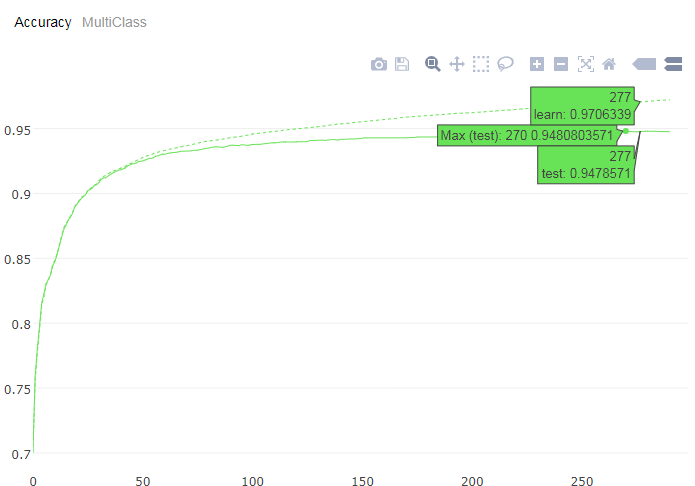

In [47]:
from IPython.display import Image
print('Learning curves')
Image(filename = "newplot_.png", width=700, height=500)

In [35]:
# Predictions
y_pred = model.predict(X_test)
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f"CatBoost: \n\nScore on training / test set: {train_score:.5f} / {test_score:.5f} \n")
print(f'accuracy_score = {accuracy_score(y_test, y_pred):.5f}')
print(f'precision_score = {precision_score(y_test, y_pred, average="macro"):.5f}')
print(f'recall_score = {recall_score(y_test, y_pred, average="macro"):.5f}')
print(f'f1_score = {f1_score(y_test, y_pred, average="macro"):.5f} \n')

CatBoost: 

Score on training / test set: 0.97733 / 0.94625 

accuracy_score = 0.94625
precision_score = 0.94665
recall_score = 0.94625
f1_score = 0.94637 



**Feature importance**

In [36]:
list(zip(features, model.get_feature_importance(prettified=False)))

[('lat', 16.74042098943401),
 ('lon', 17.86934695561513),
 ('alt', 4.838102205800082),
 ('user', 21.098002735194893),
 ('delta_time', 0.9362141137473257),
 ('distance', 1.977226263893412),
 ('speed', 3.268337439200734),
 ('acceleration', 0.7583440824868573),
 ('jerk', 1.1310400285879791),
 ('bearing', 1.6954144889320313),
 ('bearing_rate', 1.3474197496191525),
 ('elevation_change', 0.10053373879871293),
 ('elevation_speed', 0.1620251273041524),
 ('elevation_angle', 1.0348184828103824),
 ('elevation_distance', 0.05559009169438473),
 ('delta_time_10', 5.15506781314408),
 ('distance_10', 5.848274939632305),
 ('speed_10', 4.22106851059403),
 ('acceleration_10', 1.5241231492382894),
 ('jerk_10', 0.7035067038795242),
 ('bearing_10', 2.95756260686476),
 ('bearing_rate_10', 2.7433661124491207),
 ('elevation_change_10', 0.4329963072729333),
 ('elevation_speed_10', 0.32978227844061814),
 ('elevation_angle_10', 2.7186073695582067),
 ('elevation_distance_10', 0.35280771580690723)]

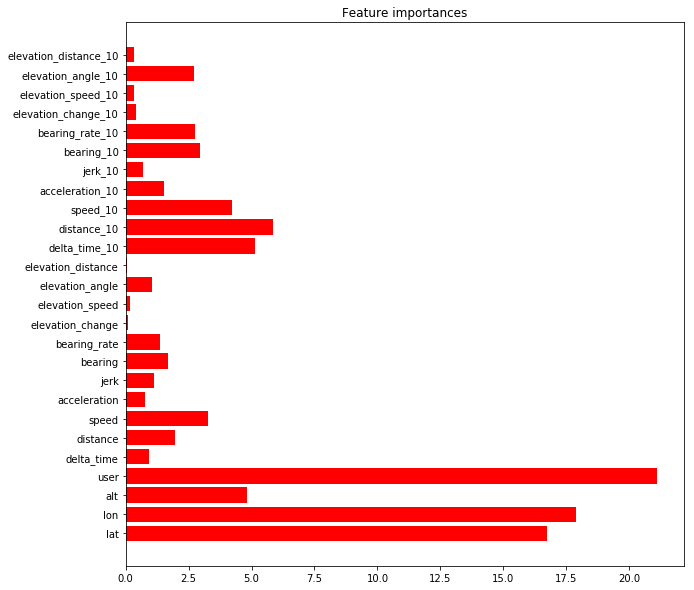

In [37]:
# Plot the feature importances of the boost
plt.figure(figsize=(10,10))
plt.title("Feature importances")
plt.barh(features, model.get_feature_importance(prettified=False),
       color="r", align="center")
plt.show()

**Confusion matrix**

In [42]:
#Confusion matrix
#https://habr.com/ru/company/ods/blog/328372/
#http://bazhenov.me/blog/2012/07/21/classification-performance-evaluation.html
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

In [43]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[727  39  27   0   0   1   6]
 [ 25 763   7   1   2   0   2]
 [ 44  19 722   0   2   1  12]
 [  4   6   0 773   6   0  11]
 [  0   1   6   7 769   0  17]
 [  2   0   1   0   0 794   3]
 [  8   1  29   5   2   4 751]]


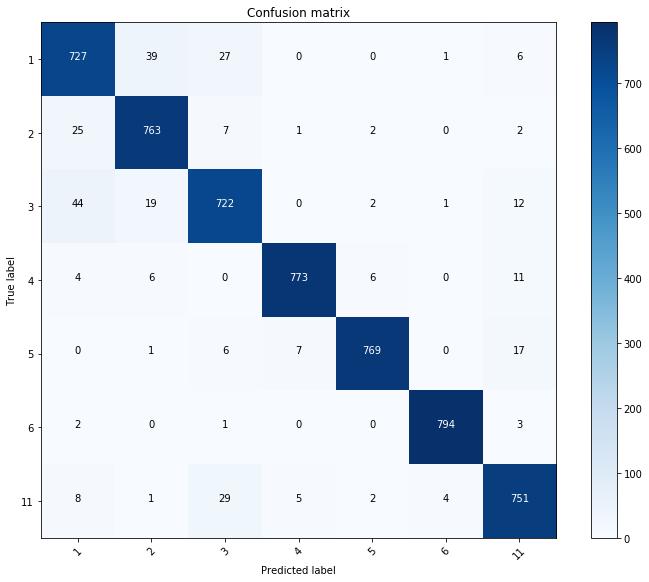

In [44]:
#plot
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cm, classes=list(count_data.index),
                      title='Confusion matrix')
plt.show()

**Report**

In [45]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           1       0.90      0.91      0.90       800
           2       0.92      0.95      0.94       800
           3       0.91      0.90      0.91       800
           4       0.98      0.97      0.97       800
           5       0.98      0.96      0.97       800
           6       0.99      0.99      0.99       800
          11       0.94      0.94      0.94       800

   micro avg       0.95      0.95      0.95      5600
   macro avg       0.95      0.95      0.95      5600
weighted avg       0.95      0.95      0.95      5600



**LightGBM BOOST**

Feature Scaling Normalized

In [41]:
#links
#https://lightgbm.readthedocs.io/en/latest/Python-API.html
#https://lightgbm.readthedocs.io/en/latest/Parameters.html#num_class

# Features
X=dff[features].values
# labels
y=dff['label'].values

#Scalling
sc = StandardScaler()
X = sc.fit_transform(X)

In [42]:
# split data to train data set and test data set
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.2, random_state=1, stratify=y_val_test)

LGBM Model

In [43]:
# classifier = lgb.LGBMClassifier(boosting_type='gbdt',
#                                 learning_rate=0.1,
#                                 max_depth=-1,
#                                 n_estimators=1000,
#                                 n_jobs=-1,
#                                 num_leaves=60,
#                                 random_state=1,
#                                 bagging_fraction=0.9,
#                                 feature_fraction=0.9,
#                                 subsample_freq=0,
#                                 bagging_freq=5,
#                                 bagging_seed=2018,
#                                 verbosity=-1)
classifier = lgb.LGBMClassifier(n_estimators=2500,learning_rate=0.01)

classifier.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
               early_stopping_rounds=10, categorical_feature='auto')

[1]	valid_0's multi_logloss: 1.91993	valid_1's multi_logloss: 1.91987
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's multi_logloss: 1.89481	valid_1's multi_logloss: 1.89478
[3]	valid_0's multi_logloss: 1.87044	valid_1's multi_logloss: 1.87037
[4]	valid_0's multi_logloss: 1.84695	valid_1's multi_logloss: 1.84693
[5]	valid_0's multi_logloss: 1.82394	valid_1's multi_logloss: 1.82394
[6]	valid_0's multi_logloss: 1.80176	valid_1's multi_logloss: 1.8018
[7]	valid_0's multi_logloss: 1.78013	valid_1's multi_logloss: 1.7802
[8]	valid_0's multi_logloss: 1.75893	valid_1's multi_logloss: 1.75899
[9]	valid_0's multi_logloss: 1.73823	valid_1's multi_logloss: 1.73831
[10]	valid_0's multi_logloss: 1.71777	valid_1's multi_logloss: 1.71792
[11]	valid_0's multi_logloss: 1.69798	valid_1's multi_logloss: 1.6982
[12]	valid_0's multi_logloss: 1.6787	valid_1's multi_logloss: 1.67896
[13]	valid_0's multi_logloss: 1.65987	valid_1's multi_logloss: 1.66021
[14]	valid_0's multi_logloss

[115]	valid_0's multi_logloss: 0.744174	valid_1's multi_logloss: 0.746251
[116]	valid_0's multi_logloss: 0.739628	valid_1's multi_logloss: 0.741721
[117]	valid_0's multi_logloss: 0.735129	valid_1's multi_logloss: 0.737296
[118]	valid_0's multi_logloss: 0.730691	valid_1's multi_logloss: 0.732871
[119]	valid_0's multi_logloss: 0.726301	valid_1's multi_logloss: 0.728502
[120]	valid_0's multi_logloss: 0.721933	valid_1's multi_logloss: 0.724162
[121]	valid_0's multi_logloss: 0.717589	valid_1's multi_logloss: 0.719853
[122]	valid_0's multi_logloss: 0.713289	valid_1's multi_logloss: 0.71556
[123]	valid_0's multi_logloss: 0.709056	valid_1's multi_logloss: 0.711328
[124]	valid_0's multi_logloss: 0.704835	valid_1's multi_logloss: 0.707133
[125]	valid_0's multi_logloss: 0.700666	valid_1's multi_logloss: 0.702976
[126]	valid_0's multi_logloss: 0.69651	valid_1's multi_logloss: 0.698821
[127]	valid_0's multi_logloss: 0.692407	valid_1's multi_logloss: 0.694728
[128]	valid_0's multi_logloss: 0.68833	v

[227]	valid_0's multi_logloss: 0.425878	valid_1's multi_logloss: 0.430618
[228]	valid_0's multi_logloss: 0.424089	valid_1's multi_logloss: 0.428832
[229]	valid_0's multi_logloss: 0.422459	valid_1's multi_logloss: 0.427251
[230]	valid_0's multi_logloss: 0.420724	valid_1's multi_logloss: 0.425522
[231]	valid_0's multi_logloss: 0.419093	valid_1's multi_logloss: 0.423907
[232]	valid_0's multi_logloss: 0.417465	valid_1's multi_logloss: 0.422296
[233]	valid_0's multi_logloss: 0.415792	valid_1's multi_logloss: 0.420673
[234]	valid_0's multi_logloss: 0.414166	valid_1's multi_logloss: 0.41906
[235]	valid_0's multi_logloss: 0.412568	valid_1's multi_logloss: 0.41749
[236]	valid_0's multi_logloss: 0.410945	valid_1's multi_logloss: 0.415878
[237]	valid_0's multi_logloss: 0.409386	valid_1's multi_logloss: 0.414366
[238]	valid_0's multi_logloss: 0.407791	valid_1's multi_logloss: 0.412789
[239]	valid_0's multi_logloss: 0.406195	valid_1's multi_logloss: 0.411213
[240]	valid_0's multi_logloss: 0.40469	v

[338]	valid_0's multi_logloss: 0.294675	valid_1's multi_logloss: 0.302369
[339]	valid_0's multi_logloss: 0.293884	valid_1's multi_logloss: 0.30161
[340]	valid_0's multi_logloss: 0.293124	valid_1's multi_logloss: 0.300869
[341]	valid_0's multi_logloss: 0.292355	valid_1's multi_logloss: 0.300155
[342]	valid_0's multi_logloss: 0.29157	valid_1's multi_logloss: 0.299405
[343]	valid_0's multi_logloss: 0.290822	valid_1's multi_logloss: 0.298673
[344]	valid_0's multi_logloss: 0.290064	valid_1's multi_logloss: 0.297952
[345]	valid_0's multi_logloss: 0.289303	valid_1's multi_logloss: 0.297227
[346]	valid_0's multi_logloss: 0.288543	valid_1's multi_logloss: 0.296494
[347]	valid_0's multi_logloss: 0.28781	valid_1's multi_logloss: 0.295807
[348]	valid_0's multi_logloss: 0.287065	valid_1's multi_logloss: 0.295085
[349]	valid_0's multi_logloss: 0.286323	valid_1's multi_logloss: 0.294394
[350]	valid_0's multi_logloss: 0.285621	valid_1's multi_logloss: 0.293728
[351]	valid_0's multi_logloss: 0.284875	v

[450]	valid_0's multi_logloss: 0.229855	valid_1's multi_logloss: 0.240954
[451]	valid_0's multi_logloss: 0.229456	valid_1's multi_logloss: 0.240573
[452]	valid_0's multi_logloss: 0.22905	valid_1's multi_logloss: 0.2402
[453]	valid_0's multi_logloss: 0.228658	valid_1's multi_logloss: 0.239833
[454]	valid_0's multi_logloss: 0.228259	valid_1's multi_logloss: 0.239447
[455]	valid_0's multi_logloss: 0.227892	valid_1's multi_logloss: 0.239102
[456]	valid_0's multi_logloss: 0.227506	valid_1's multi_logloss: 0.238752
[457]	valid_0's multi_logloss: 0.227108	valid_1's multi_logloss: 0.238387
[458]	valid_0's multi_logloss: 0.226729	valid_1's multi_logloss: 0.238017
[459]	valid_0's multi_logloss: 0.226325	valid_1's multi_logloss: 0.237647
[460]	valid_0's multi_logloss: 0.225935	valid_1's multi_logloss: 0.237292
[461]	valid_0's multi_logloss: 0.225568	valid_1's multi_logloss: 0.236945
[462]	valid_0's multi_logloss: 0.225204	valid_1's multi_logloss: 0.236598
[463]	valid_0's multi_logloss: 0.224831	v

[561]	valid_0's multi_logloss: 0.194154	valid_1's multi_logloss: 0.208209
[562]	valid_0's multi_logloss: 0.193918	valid_1's multi_logloss: 0.207983
[563]	valid_0's multi_logloss: 0.19366	valid_1's multi_logloss: 0.207758
[564]	valid_0's multi_logloss: 0.193382	valid_1's multi_logloss: 0.20752
[565]	valid_0's multi_logloss: 0.193121	valid_1's multi_logloss: 0.207299
[566]	valid_0's multi_logloss: 0.192871	valid_1's multi_logloss: 0.207072
[567]	valid_0's multi_logloss: 0.192621	valid_1's multi_logloss: 0.206839
[568]	valid_0's multi_logloss: 0.192362	valid_1's multi_logloss: 0.206607
[569]	valid_0's multi_logloss: 0.192105	valid_1's multi_logloss: 0.206382
[570]	valid_0's multi_logloss: 0.191867	valid_1's multi_logloss: 0.206182
[571]	valid_0's multi_logloss: 0.191609	valid_1's multi_logloss: 0.205958
[572]	valid_0's multi_logloss: 0.191363	valid_1's multi_logloss: 0.205734
[573]	valid_0's multi_logloss: 0.191099	valid_1's multi_logloss: 0.2055
[574]	valid_0's multi_logloss: 0.190857	va

[673]	valid_0's multi_logloss: 0.170428	valid_1's multi_logloss: 0.187582
[674]	valid_0's multi_logloss: 0.170269	valid_1's multi_logloss: 0.187458
[675]	valid_0's multi_logloss: 0.170095	valid_1's multi_logloss: 0.187302
[676]	valid_0's multi_logloss: 0.169922	valid_1's multi_logloss: 0.187147
[677]	valid_0's multi_logloss: 0.169758	valid_1's multi_logloss: 0.186996
[678]	valid_0's multi_logloss: 0.169594	valid_1's multi_logloss: 0.186855
[679]	valid_0's multi_logloss: 0.169432	valid_1's multi_logloss: 0.186714
[680]	valid_0's multi_logloss: 0.169285	valid_1's multi_logloss: 0.186589
[681]	valid_0's multi_logloss: 0.169122	valid_1's multi_logloss: 0.186447
[682]	valid_0's multi_logloss: 0.168945	valid_1's multi_logloss: 0.186285
[683]	valid_0's multi_logloss: 0.168786	valid_1's multi_logloss: 0.186131
[684]	valid_0's multi_logloss: 0.168622	valid_1's multi_logloss: 0.185999
[685]	valid_0's multi_logloss: 0.168453	valid_1's multi_logloss: 0.185827
[686]	valid_0's multi_logloss: 0.16828

[784]	valid_0's multi_logloss: 0.154409	valid_1's multi_logloss: 0.173495
[785]	valid_0's multi_logloss: 0.154268	valid_1's multi_logloss: 0.17338
[786]	valid_0's multi_logloss: 0.15415	valid_1's multi_logloss: 0.173278
[787]	valid_0's multi_logloss: 0.154014	valid_1's multi_logloss: 0.173153
[788]	valid_0's multi_logloss: 0.153884	valid_1's multi_logloss: 0.173044
[789]	valid_0's multi_logloss: 0.153743	valid_1's multi_logloss: 0.172926
[790]	valid_0's multi_logloss: 0.153614	valid_1's multi_logloss: 0.172823
[791]	valid_0's multi_logloss: 0.153474	valid_1's multi_logloss: 0.172713
[792]	valid_0's multi_logloss: 0.15335	valid_1's multi_logloss: 0.172618
[793]	valid_0's multi_logloss: 0.153227	valid_1's multi_logloss: 0.172511
[794]	valid_0's multi_logloss: 0.153095	valid_1's multi_logloss: 0.172409
[795]	valid_0's multi_logloss: 0.152971	valid_1's multi_logloss: 0.172301
[796]	valid_0's multi_logloss: 0.152834	valid_1's multi_logloss: 0.172186
[797]	valid_0's multi_logloss: 0.152716	v

[896]	valid_0's multi_logloss: 0.142098	valid_1's multi_logloss: 0.163754
[897]	valid_0's multi_logloss: 0.141999	valid_1's multi_logloss: 0.163665
[898]	valid_0's multi_logloss: 0.14192	valid_1's multi_logloss: 0.163615
[899]	valid_0's multi_logloss: 0.141838	valid_1's multi_logloss: 0.163552
[900]	valid_0's multi_logloss: 0.141733	valid_1's multi_logloss: 0.163458
[901]	valid_0's multi_logloss: 0.141629	valid_1's multi_logloss: 0.163387
[902]	valid_0's multi_logloss: 0.141542	valid_1's multi_logloss: 0.163335
[903]	valid_0's multi_logloss: 0.141442	valid_1's multi_logloss: 0.163232
[904]	valid_0's multi_logloss: 0.141356	valid_1's multi_logloss: 0.163173
[905]	valid_0's multi_logloss: 0.141264	valid_1's multi_logloss: 0.163114
[906]	valid_0's multi_logloss: 0.141167	valid_1's multi_logloss: 0.163043
[907]	valid_0's multi_logloss: 0.141075	valid_1's multi_logloss: 0.162988
[908]	valid_0's multi_logloss: 0.140975	valid_1's multi_logloss: 0.162899
[909]	valid_0's multi_logloss: 0.140883

[1007]	valid_0's multi_logloss: 0.132303	valid_1's multi_logloss: 0.156608
[1008]	valid_0's multi_logloss: 0.132236	valid_1's multi_logloss: 0.15658
[1009]	valid_0's multi_logloss: 0.132163	valid_1's multi_logloss: 0.156522
[1010]	valid_0's multi_logloss: 0.132076	valid_1's multi_logloss: 0.15645
[1011]	valid_0's multi_logloss: 0.132008	valid_1's multi_logloss: 0.156416
[1012]	valid_0's multi_logloss: 0.131922	valid_1's multi_logloss: 0.156347
[1013]	valid_0's multi_logloss: 0.131852	valid_1's multi_logloss: 0.156298
[1014]	valid_0's multi_logloss: 0.131782	valid_1's multi_logloss: 0.156241
[1015]	valid_0's multi_logloss: 0.131705	valid_1's multi_logloss: 0.156198
[1016]	valid_0's multi_logloss: 0.131628	valid_1's multi_logloss: 0.156129
[1017]	valid_0's multi_logloss: 0.131557	valid_1's multi_logloss: 0.15608
[1018]	valid_0's multi_logloss: 0.131471	valid_1's multi_logloss: 0.156017
[1019]	valid_0's multi_logloss: 0.131399	valid_1's multi_logloss: 0.155979
[1020]	valid_0's multi_loglo

[1117]	valid_0's multi_logloss: 0.12424	valid_1's multi_logloss: 0.150991
[1118]	valid_0's multi_logloss: 0.124175	valid_1's multi_logloss: 0.150951
[1119]	valid_0's multi_logloss: 0.124116	valid_1's multi_logloss: 0.150914
[1120]	valid_0's multi_logloss: 0.12405	valid_1's multi_logloss: 0.15087
[1121]	valid_0's multi_logloss: 0.123992	valid_1's multi_logloss: 0.150837
[1122]	valid_0's multi_logloss: 0.123926	valid_1's multi_logloss: 0.150791
[1123]	valid_0's multi_logloss: 0.123869	valid_1's multi_logloss: 0.150751
[1124]	valid_0's multi_logloss: 0.123801	valid_1's multi_logloss: 0.15071
[1125]	valid_0's multi_logloss: 0.123722	valid_1's multi_logloss: 0.150666
[1126]	valid_0's multi_logloss: 0.12365	valid_1's multi_logloss: 0.150611
[1127]	valid_0's multi_logloss: 0.123582	valid_1's multi_logloss: 0.150562
[1128]	valid_0's multi_logloss: 0.12351	valid_1's multi_logloss: 0.150503
[1129]	valid_0's multi_logloss: 0.123456	valid_1's multi_logloss: 0.150472
[1130]	valid_0's multi_logloss:

[1227]	valid_0's multi_logloss: 0.117564	valid_1's multi_logloss: 0.146454
[1228]	valid_0's multi_logloss: 0.117492	valid_1's multi_logloss: 0.146398
[1229]	valid_0's multi_logloss: 0.117436	valid_1's multi_logloss: 0.146362
[1230]	valid_0's multi_logloss: 0.117374	valid_1's multi_logloss: 0.146322
[1231]	valid_0's multi_logloss: 0.117327	valid_1's multi_logloss: 0.146296
[1232]	valid_0's multi_logloss: 0.117263	valid_1's multi_logloss: 0.146239
[1233]	valid_0's multi_logloss: 0.117206	valid_1's multi_logloss: 0.146191
[1234]	valid_0's multi_logloss: 0.117155	valid_1's multi_logloss: 0.146151
[1235]	valid_0's multi_logloss: 0.117102	valid_1's multi_logloss: 0.146125
[1236]	valid_0's multi_logloss: 0.117043	valid_1's multi_logloss: 0.146083
[1237]	valid_0's multi_logloss: 0.116987	valid_1's multi_logloss: 0.146042
[1238]	valid_0's multi_logloss: 0.11693	valid_1's multi_logloss: 0.145999
[1239]	valid_0's multi_logloss: 0.116882	valid_1's multi_logloss: 0.145968
[1240]	valid_0's multi_log

[1337]	valid_0's multi_logloss: 0.11168	valid_1's multi_logloss: 0.142362
[1338]	valid_0's multi_logloss: 0.111629	valid_1's multi_logloss: 0.142322
[1339]	valid_0's multi_logloss: 0.111579	valid_1's multi_logloss: 0.14229
[1340]	valid_0's multi_logloss: 0.111524	valid_1's multi_logloss: 0.142253
[1341]	valid_0's multi_logloss: 0.111475	valid_1's multi_logloss: 0.142225
[1342]	valid_0's multi_logloss: 0.111423	valid_1's multi_logloss: 0.142191
[1343]	valid_0's multi_logloss: 0.111371	valid_1's multi_logloss: 0.142152
[1344]	valid_0's multi_logloss: 0.111308	valid_1's multi_logloss: 0.142098
[1345]	valid_0's multi_logloss: 0.111268	valid_1's multi_logloss: 0.142076
[1346]	valid_0's multi_logloss: 0.111222	valid_1's multi_logloss: 0.142045
[1347]	valid_0's multi_logloss: 0.111151	valid_1's multi_logloss: 0.141993
[1348]	valid_0's multi_logloss: 0.111102	valid_1's multi_logloss: 0.141953
[1349]	valid_0's multi_logloss: 0.111052	valid_1's multi_logloss: 0.14192
[1350]	valid_0's multi_loglo

[1447]	valid_0's multi_logloss: 0.106294	valid_1's multi_logloss: 0.13886
[1448]	valid_0's multi_logloss: 0.106259	valid_1's multi_logloss: 0.138845
[1449]	valid_0's multi_logloss: 0.10621	valid_1's multi_logloss: 0.138815
[1450]	valid_0's multi_logloss: 0.106172	valid_1's multi_logloss: 0.138801
[1451]	valid_0's multi_logloss: 0.106134	valid_1's multi_logloss: 0.138785
[1452]	valid_0's multi_logloss: 0.106091	valid_1's multi_logloss: 0.138762
[1453]	valid_0's multi_logloss: 0.106052	valid_1's multi_logloss: 0.138738
[1454]	valid_0's multi_logloss: 0.106007	valid_1's multi_logloss: 0.138713
[1455]	valid_0's multi_logloss: 0.105949	valid_1's multi_logloss: 0.138663
[1456]	valid_0's multi_logloss: 0.105905	valid_1's multi_logloss: 0.13863
[1457]	valid_0's multi_logloss: 0.105857	valid_1's multi_logloss: 0.138601
[1458]	valid_0's multi_logloss: 0.10581	valid_1's multi_logloss: 0.138564
[1459]	valid_0's multi_logloss: 0.105767	valid_1's multi_logloss: 0.13855
[1460]	valid_0's multi_logloss

[1557]	valid_0's multi_logloss: 0.101434	valid_1's multi_logloss: 0.136035
[1558]	valid_0's multi_logloss: 0.101377	valid_1's multi_logloss: 0.135994
[1559]	valid_0's multi_logloss: 0.101323	valid_1's multi_logloss: 0.135952
[1560]	valid_0's multi_logloss: 0.101279	valid_1's multi_logloss: 0.135926
[1561]	valid_0's multi_logloss: 0.101243	valid_1's multi_logloss: 0.1359
[1562]	valid_0's multi_logloss: 0.101199	valid_1's multi_logloss: 0.13588
[1563]	valid_0's multi_logloss: 0.101166	valid_1's multi_logloss: 0.135875
[1564]	valid_0's multi_logloss: 0.10113	valid_1's multi_logloss: 0.135852
[1565]	valid_0's multi_logloss: 0.10108	valid_1's multi_logloss: 0.135811
[1566]	valid_0's multi_logloss: 0.101028	valid_1's multi_logloss: 0.135774
[1567]	valid_0's multi_logloss: 0.100972	valid_1's multi_logloss: 0.135739
[1568]	valid_0's multi_logloss: 0.100938	valid_1's multi_logloss: 0.135732
[1569]	valid_0's multi_logloss: 0.10089	valid_1's multi_logloss: 0.135708
[1570]	valid_0's multi_logloss:

[1666]	valid_0's multi_logloss: 0.0968757	valid_1's multi_logloss: 0.133472
[1667]	valid_0's multi_logloss: 0.0968374	valid_1's multi_logloss: 0.133442
[1668]	valid_0's multi_logloss: 0.0967956	valid_1's multi_logloss: 0.133421
[1669]	valid_0's multi_logloss: 0.0967587	valid_1's multi_logloss: 0.133396
[1670]	valid_0's multi_logloss: 0.0967195	valid_1's multi_logloss: 0.133385
[1671]	valid_0's multi_logloss: 0.0966795	valid_1's multi_logloss: 0.133357
[1672]	valid_0's multi_logloss: 0.0966406	valid_1's multi_logloss: 0.133333
[1673]	valid_0's multi_logloss: 0.096604	valid_1's multi_logloss: 0.133302
[1674]	valid_0's multi_logloss: 0.0965739	valid_1's multi_logloss: 0.133281
[1675]	valid_0's multi_logloss: 0.0965346	valid_1's multi_logloss: 0.133253
[1676]	valid_0's multi_logloss: 0.0964952	valid_1's multi_logloss: 0.133241
[1677]	valid_0's multi_logloss: 0.0964646	valid_1's multi_logloss: 0.13322
[1678]	valid_0's multi_logloss: 0.0964172	valid_1's multi_logloss: 0.133194
[1679]	valid_0

[1775]	valid_0's multi_logloss: 0.0928042	valid_1's multi_logloss: 0.131025
[1776]	valid_0's multi_logloss: 0.0927753	valid_1's multi_logloss: 0.131018
[1777]	valid_0's multi_logloss: 0.0927413	valid_1's multi_logloss: 0.131002
[1778]	valid_0's multi_logloss: 0.0927073	valid_1's multi_logloss: 0.13098
[1779]	valid_0's multi_logloss: 0.0926719	valid_1's multi_logloss: 0.130966
[1780]	valid_0's multi_logloss: 0.0926345	valid_1's multi_logloss: 0.130951
[1781]	valid_0's multi_logloss: 0.0925929	valid_1's multi_logloss: 0.130919
[1782]	valid_0's multi_logloss: 0.0925543	valid_1's multi_logloss: 0.130893
[1783]	valid_0's multi_logloss: 0.092518	valid_1's multi_logloss: 0.130869
[1784]	valid_0's multi_logloss: 0.0924819	valid_1's multi_logloss: 0.130852
[1785]	valid_0's multi_logloss: 0.0924584	valid_1's multi_logloss: 0.130844
[1786]	valid_0's multi_logloss: 0.0924138	valid_1's multi_logloss: 0.130822
[1787]	valid_0's multi_logloss: 0.0923873	valid_1's multi_logloss: 0.130815
[1788]	valid_0

[1884]	valid_0's multi_logloss: 0.0889164	valid_1's multi_logloss: 0.129035
[1885]	valid_0's multi_logloss: 0.0888849	valid_1's multi_logloss: 0.129024
[1886]	valid_0's multi_logloss: 0.0888345	valid_1's multi_logloss: 0.128976
[1887]	valid_0's multi_logloss: 0.0888028	valid_1's multi_logloss: 0.128954
[1888]	valid_0's multi_logloss: 0.0887648	valid_1's multi_logloss: 0.128934
[1889]	valid_0's multi_logloss: 0.088727	valid_1's multi_logloss: 0.12891
[1890]	valid_0's multi_logloss: 0.0886756	valid_1's multi_logloss: 0.128869
[1891]	valid_0's multi_logloss: 0.0886465	valid_1's multi_logloss: 0.128854
[1892]	valid_0's multi_logloss: 0.0886032	valid_1's multi_logloss: 0.128805
[1893]	valid_0's multi_logloss: 0.0885754	valid_1's multi_logloss: 0.128796
[1894]	valid_0's multi_logloss: 0.0885435	valid_1's multi_logloss: 0.128777
[1895]	valid_0's multi_logloss: 0.0884999	valid_1's multi_logloss: 0.128759
[1896]	valid_0's multi_logloss: 0.0884614	valid_1's multi_logloss: 0.128743
[1897]	valid_0

[2101]	valid_0's multi_logloss: 0.081969	valid_1's multi_logloss: 0.125221
[2102]	valid_0's multi_logloss: 0.0819352	valid_1's multi_logloss: 0.125199
[2103]	valid_0's multi_logloss: 0.0818971	valid_1's multi_logloss: 0.125177
[2104]	valid_0's multi_logloss: 0.0818657	valid_1's multi_logloss: 0.12517
[2105]	valid_0's multi_logloss: 0.0818346	valid_1's multi_logloss: 0.125152
[2106]	valid_0's multi_logloss: 0.0818044	valid_1's multi_logloss: 0.125138
[2107]	valid_0's multi_logloss: 0.0817727	valid_1's multi_logloss: 0.125116
[2108]	valid_0's multi_logloss: 0.081746	valid_1's multi_logloss: 0.125111
[2109]	valid_0's multi_logloss: 0.0817136	valid_1's multi_logloss: 0.125101
[2110]	valid_0's multi_logloss: 0.0816862	valid_1's multi_logloss: 0.125091
[2111]	valid_0's multi_logloss: 0.0816535	valid_1's multi_logloss: 0.125072
[2112]	valid_0's multi_logloss: 0.0816316	valid_1's multi_logloss: 0.125067
[2113]	valid_0's multi_logloss: 0.0816077	valid_1's multi_logloss: 0.125053
[2114]	valid_0'

[2210]	valid_0's multi_logloss: 0.0788552	valid_1's multi_logloss: 0.123692
[2211]	valid_0's multi_logloss: 0.0788302	valid_1's multi_logloss: 0.123686
[2212]	valid_0's multi_logloss: 0.0788018	valid_1's multi_logloss: 0.123668
[2213]	valid_0's multi_logloss: 0.0787714	valid_1's multi_logloss: 0.123646
[2214]	valid_0's multi_logloss: 0.0787489	valid_1's multi_logloss: 0.123635
[2215]	valid_0's multi_logloss: 0.0787182	valid_1's multi_logloss: 0.123618
[2216]	valid_0's multi_logloss: 0.0786926	valid_1's multi_logloss: 0.123619
[2217]	valid_0's multi_logloss: 0.0786691	valid_1's multi_logloss: 0.123608
[2218]	valid_0's multi_logloss: 0.0786481	valid_1's multi_logloss: 0.123605
[2219]	valid_0's multi_logloss: 0.0786234	valid_1's multi_logloss: 0.123595
[2220]	valid_0's multi_logloss: 0.0786006	valid_1's multi_logloss: 0.123575
[2221]	valid_0's multi_logloss: 0.07858	valid_1's multi_logloss: 0.123563
[2222]	valid_0's multi_logloss: 0.0785576	valid_1's multi_logloss: 0.123565
[2223]	valid_0

[2319]	valid_0's multi_logloss: 0.0760594	valid_1's multi_logloss: 0.122338
[2320]	valid_0's multi_logloss: 0.0760372	valid_1's multi_logloss: 0.122331
[2321]	valid_0's multi_logloss: 0.0760023	valid_1's multi_logloss: 0.122312
[2322]	valid_0's multi_logloss: 0.0759741	valid_1's multi_logloss: 0.122297
[2323]	valid_0's multi_logloss: 0.0759508	valid_1's multi_logloss: 0.122301
[2324]	valid_0's multi_logloss: 0.0759244	valid_1's multi_logloss: 0.122285
[2325]	valid_0's multi_logloss: 0.0758976	valid_1's multi_logloss: 0.122272
[2326]	valid_0's multi_logloss: 0.0758747	valid_1's multi_logloss: 0.122272
[2327]	valid_0's multi_logloss: 0.0758532	valid_1's multi_logloss: 0.122262
[2328]	valid_0's multi_logloss: 0.0758275	valid_1's multi_logloss: 0.122253
[2329]	valid_0's multi_logloss: 0.0758062	valid_1's multi_logloss: 0.122246
[2330]	valid_0's multi_logloss: 0.0757825	valid_1's multi_logloss: 0.122237
[2331]	valid_0's multi_logloss: 0.0757572	valid_1's multi_logloss: 0.122221
[2332]	valid

[2427]	valid_0's multi_logloss: 0.0734429	valid_1's multi_logloss: 0.121167
[2428]	valid_0's multi_logloss: 0.0734212	valid_1's multi_logloss: 0.12116
[2429]	valid_0's multi_logloss: 0.0733957	valid_1's multi_logloss: 0.121155
[2430]	valid_0's multi_logloss: 0.0733732	valid_1's multi_logloss: 0.121142
[2431]	valid_0's multi_logloss: 0.0733514	valid_1's multi_logloss: 0.121128
[2432]	valid_0's multi_logloss: 0.073319	valid_1's multi_logloss: 0.121125
[2433]	valid_0's multi_logloss: 0.0732915	valid_1's multi_logloss: 0.121111
[2434]	valid_0's multi_logloss: 0.0732693	valid_1's multi_logloss: 0.121101
[2435]	valid_0's multi_logloss: 0.0732418	valid_1's multi_logloss: 0.121084
[2436]	valid_0's multi_logloss: 0.0732191	valid_1's multi_logloss: 0.121072
[2437]	valid_0's multi_logloss: 0.0731938	valid_1's multi_logloss: 0.12106
[2438]	valid_0's multi_logloss: 0.0731663	valid_1's multi_logloss: 0.121053
[2439]	valid_0's multi_logloss: 0.0731492	valid_1's multi_logloss: 0.121045
[2440]	valid_0'

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.01, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=2500, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

Predict

In [44]:
y_pred = classifier.predict(X_test)
train_score = classifier.score(X_train, y_train)
test_score = classifier.score(X_test, y_test)

print(f"LightGBM: \n\nScore on training / test set: {train_score:.5f} / {test_score:.5f} \n")
print(f'accuracy_score = {accuracy_score(y_test, y_pred):.5f}')
print(f'precision_score = {precision_score(y_test, y_pred, average="macro"):.5f}')
print(f'recall_score = {recall_score(y_test, y_pred, average="macro"):.5f}')
print(f'f1_score = {f1_score(y_test, y_pred, average="macro"):.5f} \n')

LightGBM: 

Score on training / test set: 0.97979 / 0.95607 

accuracy_score = 0.95607
precision_score = 0.95630
recall_score = 0.95607
f1_score = 0.95614 



**Confusion matrix**

Confusion matrix, without normalization
[[735  37  24   0   0   0   4]
 [ 23 765   9   0   1   0   2]
 [ 37  15 732   0   3   0  13]
 [  3   2   0 782   2   0  11]
 [  0   0   3   0 784   0  13]
 [  1   0   1   0   0 795   3]
 [  6   1  21   4   3   4 761]]


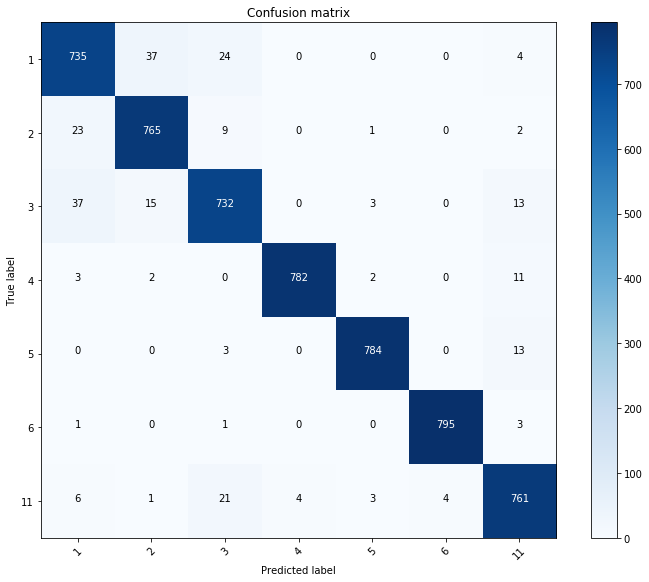

In [45]:
cm_lgb = confusion_matrix(y_test, y_pred)

#plot
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cm_lgb, classes=list(count_data.index),
                      title='Confusion matrix')
plt.show()

**Report**

In [46]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.91      0.92      0.92       800
           2       0.93      0.96      0.94       800
           3       0.93      0.92      0.92       800
           4       0.99      0.98      0.99       800
           5       0.99      0.98      0.98       800
           6       0.99      0.99      0.99       800
          11       0.94      0.95      0.95       800

   micro avg       0.96      0.96      0.96      5600
   macro avg       0.96      0.96      0.96      5600
weighted avg       0.96      0.96      0.96      5600

